라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'test230408-02_LSTMJaponicaAll.h5'

# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [3]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 날짜 데이터를 인덱스로 전환
japonica_training.set_index('mea_dt', inplace=True)
japonica_validation.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training = japonica_training.sort_index()
japonica_validation = japonica_validation.sort_index()

In [4]:
# 사용할 features 선택
japonica_training_features = japonica_training[['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features = japonica_validation[['tank_id','do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

In [5]:
# 독립 변수, 종속 변수 분리
japonica_training_features_X = japonica_training_features[['tank_id','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_features_y = japonica_training_features[['do_mg']]
japonica_validation_features_X = japonica_validation_features[['tank_id','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_features_y = japonica_validation_features[['do_mg']]

In [6]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_reshape = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_reshape.reshape((-1, 1, 9))
japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 1, 9))

In [7]:
# shape확인
nCar = japonica_training_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y.shape[0] # 데이터 개수
nVar = japonica_training_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 9
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 9
nCar: 1113748 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [8]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, 9), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name + '_best', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_features_X_reshape, japonica_training_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_features_X_reshape, japonica_validation_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70656     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,513
Trainable params: 132,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
17396/17403 [============================>.] - ETA: 0s - loss: 2.8606 - mae: 1.3022 - r_squared: 0.3424

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 124s 7ms/step - loss: 2.8605 - mae: 1.3022 - r_squared: 0.3424 - val_loss: 2.4569 - val_mae: 1.2095 - val_r_squared: -2.4658 - lr: 0.0010
Epoch 2/200
17403/17403 [==============================] - 105s 6ms/step - loss: 2.3392 - mae: 1.1759 - r_squared: 0.4592 - val_loss: 2.5778 - val_mae: 1.2316 - val_r_squared: -3.1436 - lr: 0.0010
Epoch 3/200
17403/17403 [==============================] - ETA: 0s - loss: 2.1654 - mae: 1.1169 - r_squared: 0.4981

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 119s 7ms/step - loss: 2.1654 - mae: 1.1169 - r_squared: 0.4981 - val_loss: 2.1167 - val_mae: 1.0931 - val_r_squared: -2.5268 - lr: 0.0010
Epoch 4/200
17396/17403 [============================>.] - ETA: 0s - loss: 2.0123 - mae: 1.0653 - r_squared: 0.5330

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 132s 8ms/step - loss: 2.0123 - mae: 1.0653 - r_squared: 0.5330 - val_loss: 1.8783 - val_mae: 1.0296 - val_r_squared: -1.9525 - lr: 0.0010
Epoch 5/200
17403/17403 [==============================] - 117s 7ms/step - loss: 1.9055 - mae: 1.0274 - r_squared: 0.5581 - val_loss: 1.8845 - val_mae: 1.0065 - val_r_squared: -1.8827 - lr: 0.0010
Epoch 6/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.8228 - mae: 0.9978 - r_squared: 0.5770

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 130s 7ms/step - loss: 1.8228 - mae: 0.9978 - r_squared: 0.5770 - val_loss: 1.8056 - val_mae: 0.9847 - val_r_squared: -2.1325 - lr: 0.0010
Epoch 7/200
17396/17403 [============================>.] - ETA: 0s - loss: 1.7526 - mae: 0.9719 - r_squared: 0.5930

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 132s 8ms/step - loss: 1.7526 - mae: 0.9719 - r_squared: 0.5930 - val_loss: 1.6864 - val_mae: 0.9549 - val_r_squared: -1.5811 - lr: 0.0010
Epoch 8/200
17398/17403 [============================>.] - ETA: 0s - loss: 1.6877 - mae: 0.9486 - r_squared: 0.6081

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 135s 8ms/step - loss: 1.6876 - mae: 0.9486 - r_squared: 0.6081 - val_loss: 1.5801 - val_mae: 0.9156 - val_r_squared: -1.4424 - lr: 0.0010
Epoch 9/200
17403/17403 [==============================] - 118s 7ms/step - loss: 1.6194 - mae: 0.9246 - r_squared: 0.6238 - val_loss: 1.7532 - val_mae: 0.9614 - val_r_squared: -1.8506 - lr: 0.0010
Epoch 10/200
17397/17403 [============================>.] - ETA: 0s - loss: 1.5703 - mae: 0.9064 - r_squared: 0.6350

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 130s 7ms/step - loss: 1.5703 - mae: 0.9064 - r_squared: 0.6350 - val_loss: 1.5387 - val_mae: 0.8868 - val_r_squared: -1.4813 - lr: 0.0010
Epoch 11/200
17403/17403 [==============================] - 121s 7ms/step - loss: 1.5329 - mae: 0.8918 - r_squared: 0.6434 - val_loss: 1.5645 - val_mae: 0.8958 - val_r_squared: -1.4715 - lr: 0.0010
Epoch 12/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.5029 - mae: 0.8806 - r_squared: 0.6502

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 133s 8ms/step - loss: 1.5029 - mae: 0.8806 - r_squared: 0.6502 - val_loss: 1.4669 - val_mae: 0.8677 - val_r_squared: -1.2602 - lr: 0.0010
Epoch 13/200
17403/17403 [==============================] - 126s 7ms/step - loss: 1.4768 - mae: 0.8696 - r_squared: 0.6564 - val_loss: 1.5953 - val_mae: 0.9165 - val_r_squared: -1.4530 - lr: 0.0010
Epoch 14/200
17398/17403 [============================>.] - ETA: 0s - loss: 1.4566 - mae: 0.8615 - r_squared: 0.6615

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 134s 8ms/step - loss: 1.4567 - mae: 0.8615 - r_squared: 0.6615 - val_loss: 1.4433 - val_mae: 0.8547 - val_r_squared: -1.2469 - lr: 0.0010
Epoch 15/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.4435 - mae: 0.8560 - r_squared: 0.6640

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 137s 8ms/step - loss: 1.4435 - mae: 0.8560 - r_squared: 0.6640 - val_loss: 1.3970 - val_mae: 0.8397 - val_r_squared: -1.1360 - lr: 0.0010
Epoch 16/200
17403/17403 [==============================] - 117s 7ms/step - loss: 1.4266 - mae: 0.8493 - r_squared: 0.6682 - val_loss: 1.8268 - val_mae: 0.9772 - val_r_squared: -1.8115 - lr: 0.0010
Epoch 17/200
17403/17403 [==============================] - 117s 7ms/step - loss: 1.4166 - mae: 0.8444 - r_squared: 0.6705 - val_loss: 1.4172 - val_mae: 0.8504 - val_r_squared: -1.1833 - lr: 0.0010
Epoch 18/200
17403/17403 [==============================] - ETA: 0s - loss: 1.4035 - mae: 0.8395 - r_squared: 0.6736

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 128s 7ms/step - loss: 1.4035 - mae: 0.8395 - r_squared: 0.6736 - val_loss: 1.3663 - val_mae: 0.8256 - val_r_squared: -1.1636 - lr: 0.0010
Epoch 19/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.3937 - mae: 0.8352 - r_squared: 0.6757

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 138s 8ms/step - loss: 1.3937 - mae: 0.8352 - r_squared: 0.6757 - val_loss: 1.3163 - val_mae: 0.8084 - val_r_squared: -1.0468 - lr: 0.0010
Epoch 20/200
17403/17403 [==============================] - 134s 8ms/step - loss: 1.3837 - mae: 0.8313 - r_squared: 0.6781 - val_loss: 1.3783 - val_mae: 0.8335 - val_r_squared: -1.1291 - lr: 0.0010
Epoch 21/200
17403/17403 [==============================] - 135s 8ms/step - loss: 1.3744 - mae: 0.8277 - r_squared: 0.6800 - val_loss: 1.3648 - val_mae: 0.8159 - val_r_squared: -1.0848 - lr: 0.0010
Epoch 22/200
17396/17403 [============================>.] - ETA: 0s - loss: 1.3651 - mae: 0.8238 - r_squared: 0.6822
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
17403/17403 [==============================] - 134s 8ms/step - loss: 1.3651 - mae: 0.8239 - r_squared: 0.6822 - val_loss: 1.4107 - val_mae: 0.8373 - val_r_squared: -1.2267 - lr: 0.0010
Epoch 23/200
17403/17403 [=============

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 144s 8ms/step - loss: 1.1850 - mae: 0.7555 - r_squared: 0.7241 - val_loss: 1.1678 - val_mae: 0.7490 - val_r_squared: -0.8100 - lr: 1.0000e-04
Epoch 24/200
17403/17403 [==============================] - 124s 7ms/step - loss: 1.1710 - mae: 0.7496 - r_squared: 0.7271 - val_loss: 1.1684 - val_mae: 0.7484 - val_r_squared: -0.8215 - lr: 1.0000e-04
Epoch 25/200
17397/17403 [============================>.] - ETA: 0s - loss: 1.1638 - mae: 0.7465 - r_squared: 0.7288

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 137s 8ms/step - loss: 1.1638 - mae: 0.7465 - r_squared: 0.7288 - val_loss: 1.1563 - val_mae: 0.7425 - val_r_squared: -0.8034 - lr: 1.0000e-04
Epoch 26/200
17403/17403 [==============================] - 138s 8ms/step - loss: 1.1586 - mae: 0.7444 - r_squared: 0.7297 - val_loss: 1.1612 - val_mae: 0.7451 - val_r_squared: -0.8132 - lr: 1.0000e-04
Epoch 27/200
17398/17403 [============================>.] - ETA: 0s - loss: 1.1538 - mae: 0.7427 - r_squared: 0.7310

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 148s 8ms/step - loss: 1.1537 - mae: 0.7426 - r_squared: 0.7310 - val_loss: 1.1456 - val_mae: 0.7383 - val_r_squared: -0.7900 - lr: 1.0000e-04
Epoch 28/200
17403/17403 [==============================] - 144s 8ms/step - loss: 1.1495 - mae: 0.7408 - r_squared: 0.7320 - val_loss: 1.1520 - val_mae: 0.7402 - val_r_squared: -0.7809 - lr: 1.0000e-04
Epoch 29/200
17403/17403 [==============================] - 146s 8ms/step - loss: 1.1454 - mae: 0.7394 - r_squared: 0.7329 - val_loss: 1.1660 - val_mae: 0.7481 - val_r_squared: -0.8024 - lr: 1.0000e-04
Epoch 30/200
17398/17403 [============================>.] - ETA: 0s - loss: 1.1420 - mae: 0.7378 - r_squared: 0.7341

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 158s 9ms/step - loss: 1.1420 - mae: 0.7378 - r_squared: 0.7341 - val_loss: 1.1410 - val_mae: 0.7368 - val_r_squared: -0.7655 - lr: 1.0000e-04
Epoch 31/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.1386 - mae: 0.7365 - r_squared: 0.7346

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 157s 9ms/step - loss: 1.1385 - mae: 0.7365 - r_squared: 0.7346 - val_loss: 1.1366 - val_mae: 0.7367 - val_r_squared: -0.7655 - lr: 1.0000e-04
Epoch 32/200
17403/17403 [==============================] - 137s 8ms/step - loss: 1.1358 - mae: 0.7351 - r_squared: 0.7352 - val_loss: 1.1551 - val_mae: 0.7410 - val_r_squared: -0.8148 - lr: 1.0000e-04
Epoch 33/200
17397/17403 [============================>.] - ETA: 0s - loss: 1.1334 - mae: 0.7343 - r_squared: 0.7357

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 148s 9ms/step - loss: 1.1333 - mae: 0.7343 - r_squared: 0.7357 - val_loss: 1.1255 - val_mae: 0.7321 - val_r_squared: -0.7430 - lr: 1.0000e-04
Epoch 34/200
17403/17403 [==============================] - 129s 7ms/step - loss: 1.1298 - mae: 0.7331 - r_squared: 0.7366 - val_loss: 1.1365 - val_mae: 0.7363 - val_r_squared: -0.7637 - lr: 1.0000e-04
Epoch 35/200
17403/17403 [==============================] - ETA: 0s - loss: 1.1276 - mae: 0.7320 - r_squared: 0.7371

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 138s 8ms/step - loss: 1.1276 - mae: 0.7320 - r_squared: 0.7371 - val_loss: 1.1209 - val_mae: 0.7304 - val_r_squared: -0.7442 - lr: 1.0000e-04
Epoch 36/200
17403/17403 [==============================] - 142s 8ms/step - loss: 1.1248 - mae: 0.7309 - r_squared: 0.7380 - val_loss: 1.1241 - val_mae: 0.7314 - val_r_squared: -0.7382 - lr: 1.0000e-04
Epoch 37/200
17398/17403 [============================>.] - ETA: 0s - loss: 1.1224 - mae: 0.7298 - r_squared: 0.7385

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 152s 9ms/step - loss: 1.1224 - mae: 0.7298 - r_squared: 0.7385 - val_loss: 1.1148 - val_mae: 0.7285 - val_r_squared: -0.7151 - lr: 1.0000e-04
Epoch 38/200
17403/17403 [==============================] - 138s 8ms/step - loss: 1.1198 - mae: 0.7288 - r_squared: 0.7391 - val_loss: 1.1264 - val_mae: 0.7319 - val_r_squared: -0.7496 - lr: 1.0000e-04
Epoch 39/200
17403/17403 [==============================] - 139s 8ms/step - loss: 1.1168 - mae: 0.7276 - r_squared: 0.7398 - val_loss: 1.1242 - val_mae: 0.7306 - val_r_squared: -0.7382 - lr: 1.0000e-04
Epoch 40/200
17395/17403 [============================>.] - ETA: 0s - loss: 1.1145 - mae: 0.7265 - r_squared: 0.7402
Epoch 40: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
17403/17403 [==============================] - 140s 8ms/step - loss: 1.1145 - mae: 0.7265 - r_squared: 0.7402 - val_loss: 1.1233 - val_mae: 0.7283 - val_r_squared: -0.7340 - lr: 1.0000e-04
Epoch 41/200
17399/1740

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 147s 8ms/step - loss: 1.0936 - mae: 0.7181 - r_squared: 0.7449 - val_loss: 1.0914 - val_mae: 0.7174 - val_r_squared: -0.6882 - lr: 1.0000e-05
Epoch 42/200
17403/17403 [==============================] - 128s 7ms/step - loss: 1.0921 - mae: 0.7175 - r_squared: 0.7455 - val_loss: 1.0914 - val_mae: 0.7179 - val_r_squared: -0.6810 - lr: 1.0000e-05
Epoch 43/200
17403/17403 [==============================] - ETA: 0s - loss: 1.0915 - mae: 0.7174 - r_squared: 0.7453

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 141s 8ms/step - loss: 1.0915 - mae: 0.7174 - r_squared: 0.7453 - val_loss: 1.0908 - val_mae: 0.7176 - val_r_squared: -0.6826 - lr: 1.0000e-05
Epoch 44/200
17402/17403 [============================>.] - ETA: 0s - loss: 1.0913 - mae: 0.7173 - r_squared: 0.7455

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 154s 9ms/step - loss: 1.0913 - mae: 0.7173 - r_squared: 0.7455 - val_loss: 1.0903 - val_mae: 0.7164 - val_r_squared: -0.6864 - lr: 1.0000e-05
Epoch 45/200
17402/17403 [============================>.] - ETA: 0s - loss: 1.0910 - mae: 0.7170 - r_squared: 0.7455

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 205s 12ms/step - loss: 1.0910 - mae: 0.7170 - r_squared: 0.7455 - val_loss: 1.0896 - val_mae: 0.7171 - val_r_squared: -0.6840 - lr: 1.0000e-05
Epoch 46/200
17403/17403 [==============================] - 172s 10ms/step - loss: 1.0906 - mae: 0.7169 - r_squared: 0.7455 - val_loss: 1.0904 - val_mae: 0.7170 - val_r_squared: -0.6769 - lr: 1.0000e-05
Epoch 47/200
17403/17403 [==============================] - 171s 10ms/step - loss: 1.0903 - mae: 0.7167 - r_squared: 0.7457 - val_loss: 1.0899 - val_mae: 0.7168 - val_r_squared: -0.6782 - lr: 1.0000e-05
Epoch 48/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0901 - mae: 0.7166 - r_squared: 0.7459

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 180s 10ms/step - loss: 1.0901 - mae: 0.7166 - r_squared: 0.7459 - val_loss: 1.0893 - val_mae: 0.7163 - val_r_squared: -0.6838 - lr: 1.0000e-05
Epoch 49/200
17403/17403 [==============================] - 178s 10ms/step - loss: 1.0898 - mae: 0.7165 - r_squared: 0.7459 - val_loss: 1.0907 - val_mae: 0.7170 - val_r_squared: -0.6815 - lr: 1.0000e-05
Epoch 50/200
17402/17403 [============================>.] - ETA: 0s - loss: 1.0894 - mae: 0.7164 - r_squared: 0.7457

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 188s 11ms/step - loss: 1.0894 - mae: 0.7164 - r_squared: 0.7457 - val_loss: 1.0887 - val_mae: 0.7163 - val_r_squared: -0.6828 - lr: 1.0000e-05
Epoch 51/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0891 - mae: 0.7162 - r_squared: 0.7459

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 192s 11ms/step - loss: 1.0891 - mae: 0.7162 - r_squared: 0.7459 - val_loss: 1.0877 - val_mae: 0.7156 - val_r_squared: -0.6796 - lr: 1.0000e-05
Epoch 52/200
17403/17403 [==============================] - 185s 11ms/step - loss: 1.0888 - mae: 0.7161 - r_squared: 0.7461 - val_loss: 1.0895 - val_mae: 0.7160 - val_r_squared: -0.6824 - lr: 1.0000e-05
Epoch 53/200
17403/17403 [==============================] - 184s 11ms/step - loss: 1.0885 - mae: 0.7159 - r_squared: 0.7461 - val_loss: 1.0888 - val_mae: 0.7164 - val_r_squared: -0.6775 - lr: 1.0000e-05
Epoch 54/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0884 - mae: 0.7159 - r_squared: 0.7461

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 196s 11ms/step - loss: 1.0883 - mae: 0.7159 - r_squared: 0.7461 - val_loss: 1.0871 - val_mae: 0.7159 - val_r_squared: -0.6748 - lr: 1.0000e-05
Epoch 55/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0880 - mae: 0.7157 - r_squared: 0.7462

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 197s 11ms/step - loss: 1.0880 - mae: 0.7157 - r_squared: 0.7463 - val_loss: 1.0868 - val_mae: 0.7155 - val_r_squared: -0.6847 - lr: 1.0000e-05
Epoch 56/200
17396/17403 [============================>.] - ETA: 0s - loss: 1.0877 - mae: 0.7155 - r_squared: 0.7464

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 163s 9ms/step - loss: 1.0877 - mae: 0.7155 - r_squared: 0.7464 - val_loss: 1.0862 - val_mae: 0.7150 - val_r_squared: -0.6772 - lr: 1.0000e-05
Epoch 57/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0874 - mae: 0.7154 - r_squared: 0.7463

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 178s 10ms/step - loss: 1.0874 - mae: 0.7154 - r_squared: 0.7463 - val_loss: 1.0856 - val_mae: 0.7147 - val_r_squared: -0.6730 - lr: 1.0000e-05
Epoch 58/200
17403/17403 [==============================] - 183s 11ms/step - loss: 1.0871 - mae: 0.7153 - r_squared: 0.7465 - val_loss: 1.0860 - val_mae: 0.7150 - val_r_squared: -0.6761 - lr: 1.0000e-05
Epoch 59/200
17403/17403 [==============================] - 184s 11ms/step - loss: 1.0868 - mae: 0.7152 - r_squared: 0.7465 - val_loss: 1.0864 - val_mae: 0.7151 - val_r_squared: -0.6788 - lr: 1.0000e-05
Epoch 60/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0866 - mae: 0.7150 - r_squared: 0.7465

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 194s 11ms/step - loss: 1.0866 - mae: 0.7150 - r_squared: 0.7465 - val_loss: 1.0848 - val_mae: 0.7150 - val_r_squared: -0.6756 - lr: 1.0000e-05
Epoch 61/200
17403/17403 [==============================] - 203s 12ms/step - loss: 1.0862 - mae: 0.7150 - r_squared: 0.7467 - val_loss: 1.0858 - val_mae: 0.7146 - val_r_squared: -0.6745 - lr: 1.0000e-05
Epoch 62/200
17403/17403 [==============================] - 202s 12ms/step - loss: 1.0859 - mae: 0.7148 - r_squared: 0.7470 - val_loss: 1.0863 - val_mae: 0.7150 - val_r_squared: -0.6738 - lr: 1.0000e-05
Epoch 63/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0857 - mae: 0.7147 - r_squared: 0.7471

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 212s 12ms/step - loss: 1.0857 - mae: 0.7147 - r_squared: 0.7470 - val_loss: 1.0844 - val_mae: 0.7140 - val_r_squared: -0.6767 - lr: 1.0000e-05
Epoch 64/200
17403/17403 [==============================] - 205s 12ms/step - loss: 1.0853 - mae: 0.7146 - r_squared: 0.7469 - val_loss: 1.0847 - val_mae: 0.7147 - val_r_squared: -0.6764 - lr: 1.0000e-05
Epoch 65/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0852 - mae: 0.7145 - r_squared: 0.7467

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 216s 12ms/step - loss: 1.0852 - mae: 0.7145 - r_squared: 0.7467 - val_loss: 1.0836 - val_mae: 0.7143 - val_r_squared: -0.6702 - lr: 1.0000e-05
Epoch 66/200
17403/17403 [==============================] - 185s 11ms/step - loss: 1.0848 - mae: 0.7144 - r_squared: 0.7470 - val_loss: 1.0846 - val_mae: 0.7141 - val_r_squared: -0.6736 - lr: 1.0000e-05
Epoch 67/200
17403/17403 [==============================] - 183s 10ms/step - loss: 1.0846 - mae: 0.7143 - r_squared: 0.7472 - val_loss: 1.0841 - val_mae: 0.7135 - val_r_squared: -0.6679 - lr: 1.0000e-05
Epoch 68/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0843 - mae: 0.7141 - r_squared: 0.7471

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 193s 11ms/step - loss: 1.0843 - mae: 0.7141 - r_squared: 0.7471 - val_loss: 1.0832 - val_mae: 0.7142 - val_r_squared: -0.6710 - lr: 1.0000e-05
Epoch 69/200
17403/17403 [==============================] - 204s 12ms/step - loss: 1.0840 - mae: 0.7140 - r_squared: 0.7473 - val_loss: 1.0833 - val_mae: 0.7138 - val_r_squared: -0.6687 - lr: 1.0000e-05
Epoch 70/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0838 - mae: 0.7140 - r_squared: 0.7474

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 217s 12ms/step - loss: 1.0838 - mae: 0.7140 - r_squared: 0.7474 - val_loss: 1.0828 - val_mae: 0.7135 - val_r_squared: -0.6705 - lr: 1.0000e-05
Epoch 71/200
17403/17403 [==============================] - 165s 9ms/step - loss: 1.0835 - mae: 0.7138 - r_squared: 0.7473 - val_loss: 1.0829 - val_mae: 0.7137 - val_r_squared: -0.6698 - lr: 1.0000e-05
Epoch 72/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0832 - mae: 0.7137 - r_squared: 0.7473

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 171s 10ms/step - loss: 1.0832 - mae: 0.7137 - r_squared: 0.7473 - val_loss: 1.0826 - val_mae: 0.7131 - val_r_squared: -0.6663 - lr: 1.0000e-05
Epoch 73/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0830 - mae: 0.7135 - r_squared: 0.7473

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 166s 10ms/step - loss: 1.0830 - mae: 0.7136 - r_squared: 0.7473 - val_loss: 1.0820 - val_mae: 0.7133 - val_r_squared: -0.6664 - lr: 1.0000e-05
Epoch 74/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0827 - mae: 0.7135 - r_squared: 0.7474

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 173s 10ms/step - loss: 1.0828 - mae: 0.7135 - r_squared: 0.7474 - val_loss: 1.0817 - val_mae: 0.7127 - val_r_squared: -0.6686 - lr: 1.0000e-05
Epoch 75/200
17403/17403 [==============================] - 166s 10ms/step - loss: 1.0824 - mae: 0.7133 - r_squared: 0.7477 - val_loss: 1.0826 - val_mae: 0.7138 - val_r_squared: -0.6633 - lr: 1.0000e-05
Epoch 76/200
17403/17403 [==============================] - 166s 10ms/step - loss: 1.0821 - mae: 0.7132 - r_squared: 0.7477 - val_loss: 1.0817 - val_mae: 0.7133 - val_r_squared: -0.6693 - lr: 1.0000e-05
Epoch 77/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0819 - mae: 0.7132 - r_squared: 0.7476

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 178s 10ms/step - loss: 1.0819 - mae: 0.7132 - r_squared: 0.7476 - val_loss: 1.0810 - val_mae: 0.7119 - val_r_squared: -0.6655 - lr: 1.0000e-05
Epoch 78/200
17403/17403 [==============================] - 154s 9ms/step - loss: 1.0815 - mae: 0.7130 - r_squared: 0.7480 - val_loss: 1.0810 - val_mae: 0.7131 - val_r_squared: -0.6602 - lr: 1.0000e-05
Epoch 79/200
17403/17403 [==============================] - 154s 9ms/step - loss: 1.0814 - mae: 0.7129 - r_squared: 0.7478 - val_loss: 1.0814 - val_mae: 0.7134 - val_r_squared: -0.6612 - lr: 1.0000e-05
Epoch 80/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0811 - mae: 0.7127 - r_squared: 0.7480

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 165s 9ms/step - loss: 1.0811 - mae: 0.7127 - r_squared: 0.7480 - val_loss: 1.0794 - val_mae: 0.7126 - val_r_squared: -0.6647 - lr: 1.0000e-05
Epoch 81/200
17403/17403 [==============================] - 155s 9ms/step - loss: 1.0808 - mae: 0.7126 - r_squared: 0.7477 - val_loss: 1.0797 - val_mae: 0.7124 - val_r_squared: -0.6696 - lr: 1.0000e-05
Epoch 82/200
17403/17403 [==============================] - 153s 9ms/step - loss: 1.0806 - mae: 0.7125 - r_squared: 0.7481 - val_loss: 1.0828 - val_mae: 0.7143 - val_r_squared: -0.6660 - lr: 1.0000e-05
Epoch 83/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0802 - mae: 0.7125 - r_squared: 0.7481
Epoch 83: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
17403/17403 [==============================] - 151s 9ms/step - loss: 1.0802 - mae: 0.7125 - r_squared: 0.7481 - val_loss: 1.0795 - val_mae: 0.7119 - val_r_squared: -0.6688 - lr: 1.0000e-05
Epoch 84/200
17398/1740

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 161s 9ms/step - loss: 1.0781 - mae: 0.7115 - r_squared: 0.7487 - val_loss: 1.0778 - val_mae: 0.7113 - val_r_squared: -0.6609 - lr: 1.0000e-06
Epoch 85/200
17396/17403 [============================>.] - ETA: 0s - loss: 1.0778 - mae: 0.7113 - r_squared: 0.7486

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 160s 9ms/step - loss: 1.0778 - mae: 0.7113 - r_squared: 0.7486 - val_loss: 1.0775 - val_mae: 0.7113 - val_r_squared: -0.6607 - lr: 1.0000e-06
Epoch 86/200
17403/17403 [==============================] - 152s 9ms/step - loss: 1.0778 - mae: 0.7114 - r_squared: 0.7486 - val_loss: 1.0775 - val_mae: 0.7113 - val_r_squared: -0.6606 - lr: 1.0000e-06
Epoch 87/200
17403/17403 [==============================] - 152s 9ms/step - loss: 1.0777 - mae: 0.7114 - r_squared: 0.7486 - val_loss: 1.0777 - val_mae: 0.7114 - val_r_squared: -0.6624 - lr: 1.0000e-06
Epoch 88/200
17401/17403 [============================>.] - ETA: 0s - loss: 1.0777 - mae: 0.7114 - r_squared: 0.7487

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets



Epoch 88: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
17403/17403 [==============================] - 162s 9ms/step - loss: 1.0777 - mae: 0.7114 - r_squared: 0.7487 - val_loss: 1.0775 - val_mae: 0.7114 - val_r_squared: -0.6597 - lr: 1.0000e-06
Epoch 89/200
17400/17403 [============================>.] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7486

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 162s 9ms/step - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7486 - val_loss: 1.0774 - val_mae: 0.7113 - val_r_squared: -0.6602 - lr: 1.0000e-07
Epoch 90/200
17403/17403 [==============================] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 170s 10ms/step - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0774 - val_mae: 0.7113 - val_r_squared: -0.6603 - lr: 1.0000e-07
Epoch 91/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7486

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 157s 9ms/step - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7486 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6603 - lr: 1.0000e-07
Epoch 92/200
17397/17403 [============================>.] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets



Epoch 92: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
17403/17403 [==============================] - 176s 10ms/step - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6605 - lr: 1.0000e-07
Epoch 93/200
17403/17403 [==============================] - 147s 8ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7486 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6605 - lr: 1.0000e-08
Epoch 94/200
17403/17403 [==============================] - 146s 8ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-08
Epoch 95/200
17397/17403 [============================>.] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets



Epoch 95: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
17403/17403 [==============================] - 148s 9ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-08
Epoch 96/200
17402/17403 [============================>.] - ETA: 0s - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7487

INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


INFO:tensorflow:Assets written to: test230408-02_LSTMJaponicaAll.h5_best\assets


17403/17403 [==============================] - 150s 9ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7487 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-09
Epoch 97/200
17403/17403 [==============================] - 150s 9ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7489 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-09
Epoch 98/200
17399/17403 [============================>.] - ETA: 0s - loss: 1.0774 - mae: 0.7113 - r_squared: 0.7488
Epoch 98: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
17403/17403 [==============================] - 151s 9ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-09
Epoch 99/200
17403/17403 [==============================] - 151s 9ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: 0.7488 - val_loss: 1.0773 - val_mae: 0.7113 - val_r_squared: -0.6604 - lr: 1.0000e-10
Epoch 100/200
17403/1740

모델 평가

In [9]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name, custom_objects={'r_squared': r_squared})

[[-0.44108826  1.3469074  -2.5189283  ... -0.06460469  0.5423528
  -0.21531749]
 [-0.27203858 -1.3973093   1.3090011  ...  0.01492334  0.82307893
  -0.16906409]
 [-0.4725386  -0.13643573 -0.9617075  ... -0.10704377  0.8765599
  -0.36908102]
 ...
 [-0.3284337  -0.11315152 -0.34182805 ...  0.05455729  0.3806609
  -0.45583504]
 [ 0.1695643  -0.29263726 -0.3629542  ...  0.02590977  0.08695735
  -0.00844357]
 [ 0.3024938  -0.2333854  -0.28070116 ... -0.10026499  0.04530504
  -0.11602821]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


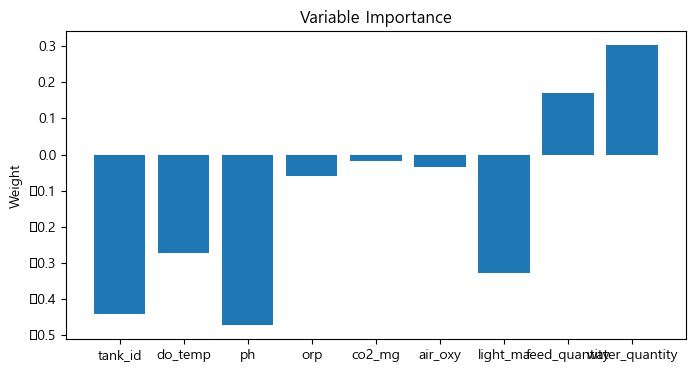

In [10]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(9), weights[:, 0])
ax.set_xticks(range(9))
ax.set_xticklabels(['tank_id','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

34805/34805 [==============================] - 66s 2ms/step


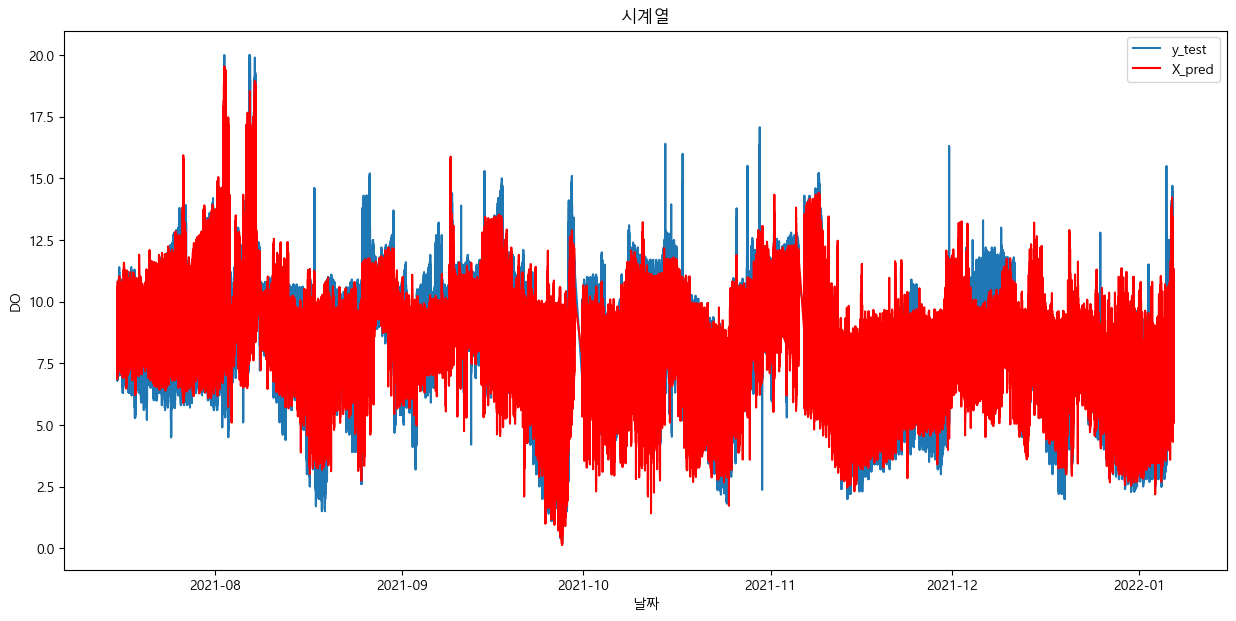

34805/34805 [==============================] - 81s 2ms/step - loss: 1.0773 - mae: 0.7113 - r_squared: -0.7094
MSE // MAE // R-squared  [1.0773377418518066, 0.7112656235694885, -0.7094428539276123]


In [11]:
grapeNEva(model, japonica_validation_features_X_reshape, japonica_validation_features_y)

In [12]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-08-27 00:00:00':'2021-08-27 23:59:59']
oneday_X_test = one_day_data[['tank_id','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, 9))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1440 nVar: 9
nCar: 1440 nVar: 1


45/45 [==============================] - 0s 2ms/step


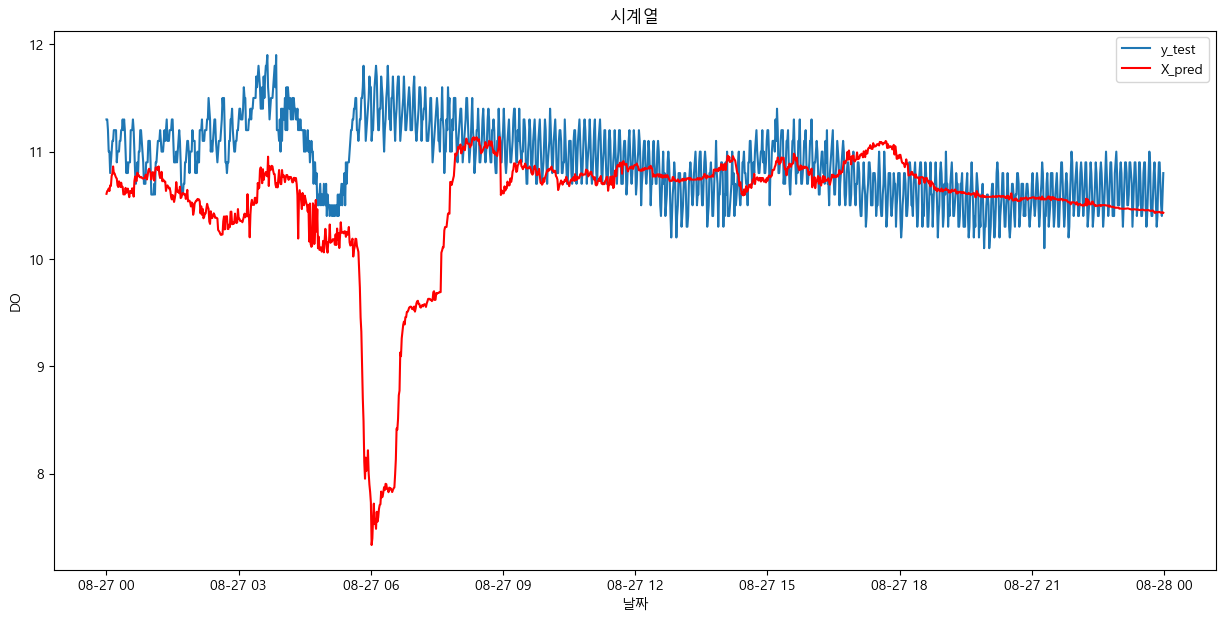

45/45 [==============================] - 0s 3ms/step - loss: 0.7393 - mae: 0.4932 - r_squared: -17.3549
MSE // MAE // R-squared  [0.7393144369125366, 0.4932183027267456, -17.354949951171875]


In [13]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)